In [ ]:
# STN model development notes

## 28th May 2015
This labbook describes the work I've been doing investigating Izhikevich neurons for a spiking basal ganglia model.

So far, I've developed a matlab based analysis environment which allows me to run a SpineML model, read the results and then show nullcline and quiver plots.

I've reproduced Izhikevich's models from his 2003 IEEE paper; see Izhi2003_RS, Izhi2003_TC, etc.

I've found a somewhat suitable STN neuron model and a somewhat suitable GPe neuron model. I have still to implement the MSNs which Dave Buxton is using (must obtain these from him).

I've considered whether to use an ipython notebook to write this document, but have thus far only ported load_sc_data.m to python. When the mood takes me, I'll port the Izhikevich analysis code to python, as this would be great for analysis; much better than a document like this. *(Update 11th June: I have done enough ipython work now to write my labbook here in ipython)*

### STN neuron model

I'm basing the STN neuron on the model described in Terman et al. 2002 (Activity Patterns in a Model for the Subthalamopallidal Network of the Basal Ganglia). The Terman model is based upon data from Bevan & Wilson 1999, Bevan et al. 2000 and Beurrier et al. 2000.

These neurons are spontaneously active, firing at about 3 s$^{-1}$  and rebound bursting. The model I have parameterized shows these features, with around the right firing rate vs. current behaviour. The one feature I've not yet successfully shown is the scaling of the bursting time with the hyperpolarization period.

The starting point for this model was Izhikevic's thalamo cortical model (see Izhi2003_TC). This showed the right sort of rebound bursting, but with the wrong timescale. I modified the model to scale out time, ending up with the following model:

$$\dot{v} = ATv^2 + BTv + CT -uT + I$$
$$\dot{u} = aT(bv-u)$$
$$v>v_{peak}: v\leftarrow c, u \leftarrow u+d$$

Note that I kept A, B and C and introduced a time scaling factor T to almost all terms, with the exception of the injected current I. To build the model, I'll let A' = AT; B'=BT; C'=CT; a'=aT.

See images for the encoding of the model in SpineCreator:

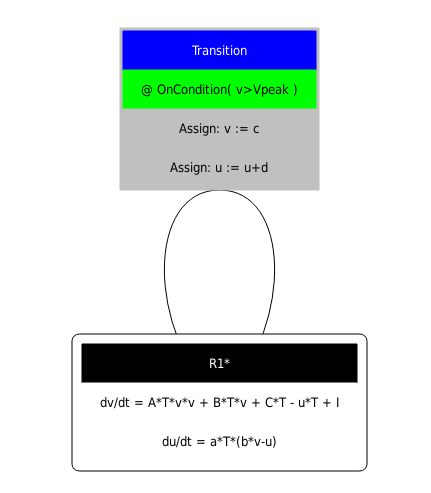

In [2]:
from IPython.display import Image
Image(filename='IzhiPaper_tscaled.png') 

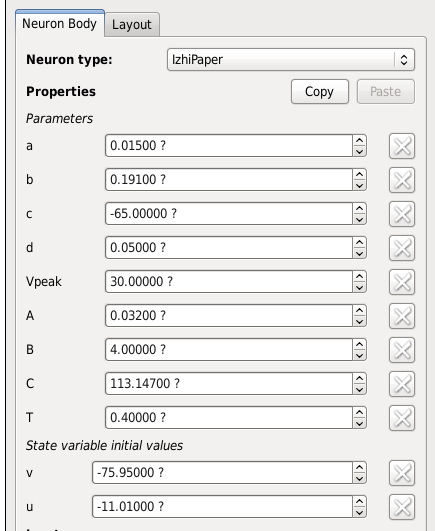

In [4]:
Image(filename='STN_params.png') 

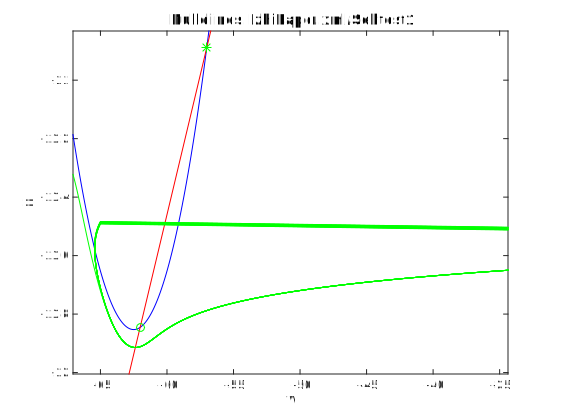

In [5]:
# Here's the STN model with zero input current showing cyclic spiking:
from IPython.display import SVG
SVG(filename='stn_zero_current.svg')

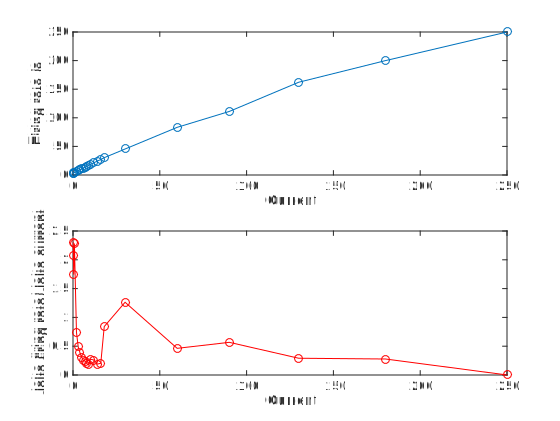

In [6]:
# Firing rate vs. current and rebound bursting (rebound burst graph also shows zero-current spiking rate):
SVG(filename='stn_firing_vs_current.svg')

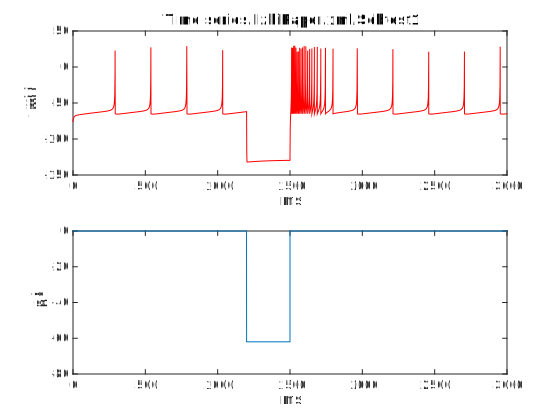

In [7]:
# Rebound bursting:
SVG(filename='stn_rebound_burst.svg')

### *An update on the above - 11th June*

I made a factor of 10 error on the firing rate, so the model is not behaving as we need it to. I may be able to fix this simply by scaling the input current.

## 10th June 2015

I've been working on the Izhikevich neurons for a while now - see for example ABC_to_IV.ipynb. I've developed analysis software in matlab to process and visualise the run of a single Izhikevich model in a SpineML model. I've also developed a scheme to process and visualise the same model in an ipython notebook - see run_model.ipynb.

Here, I'm going to write some notes about developing my STN neuron. The starting point is Izhikevich's 2003 paper; the TC neuron from Fig 2. This shows rebound bursting, but it doesn't show intrinsic firing and its current/firing rate curve is wrong for our purposes.

I'm aiming to produce a neuron with roughly the properties of that in Terman et al.

I've been working with a scheme where I define a series of experiments which have different constant current inputs, but this is becoming unwieldy, so next job is to hack spineml_preflight so that it can set a constant current for the experiment in question, overriding whatever is in there currently.

Constant current feature is done, see commit 997ada6 in SpineML_PreFlight.

I did some work to convert ABC to IV format. What does the STN model look like in that form, and can I tweak the firing vs. current by scaling the current? Also, can I introduce my time scaling to the IV form - it is a helpful means to scale all the firing rates where necessary.

The equation for the system becomes:

$${C_a \dot{v}\over T} = k(v-v_r)(v-v_t) -u + b v_r + {I\over S_I}$$

$${\dot{u}\over T} = a(b(v-v_r)-u + bv_r)$$

$$v>v_{peak}: v\leftarrow c, u \leftarrow u+d$$

Note the time scaling parameter $T$, the current scaling parameter, $S_I$.

See this behaviour in the model Izhi_STN_IV.

## 11th June - The STN model params

In [8]:
# These are the working default parameters for the STN model. Underscore prefix means "default value"
_a=0.02; _b=0.191; _c=-65; _d=0.05;
_k=0.032; _Ca=2.5;
_vr=-57.01245; _vt=-67.98755; 
_SI=5; _T=1; 
_vpeak=30;
_vinit=-70; _uinit=-10;

## Run the SpineML STN model

In [9]:
# Run Izhi_STN_IV
def run_ivscaled_model (expt=0,lowerV=-80, upperV=0, qvloweru=-16, qvupperu=-4,
                        qpspacing=4, qpveclen=90):

    import sys
    sys.path.append("../analysis")
    
    # Where's the model and data?
    modeldir = '/home/seb/izhibg/GPR_Izhikevich/Izhi_STN_IV';
    population = 'Sebtest2'
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemltmp = spineml2brahms+'/temp/log/';

    # Read the model xml
    import read_iv_model_xml as ivread
    a,b,c,d,k,Ca,vr,vt,SI,T,vpeak,vinit,uinit = ivread.read_iv_model_xml (modeldir,expt)

    print 'params: abcd:', a, b, c, d, 'k,Ca,vr,vt:', k, Ca, vr, vt, ' SI,T:', SI,T, ' vpeak,vinit,uinit:', vpeak,vinit,uinit
    
    constI = 0;
    
    # Execute the model
    import os
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                 `expt`+' ; popd"'; #+' -c'+population+':I:'+`constI`
    os.system(spinemlcmd);

    # load the data from the model run
    import load_sc_data as lsd
    v, v_count, t, nn, dt = lsd.load_sc_data (spinemltmp+population+'_v_log.bin');
    u, u_count, tu, nnu, dtu = lsd.load_sc_data (spinemltmp+population+'_u_log.bin');

    import numpy as np
    
    # Compute nullclines
    Vn = np.linspace (lowerV, upperV, 1000);
    I = np.zeros(v_count)+constI;
    nc_v = k*(Vn-vr)*(Vn-vt) + b*vr + (I[:len(Vn)]/SI) ;
    nc_u = Vn*b;

    # Compute vector field
    if qpspacing != 0:
        thescale = abs(lowerV-upperV)/qpspacing;
        Vgv = np.linspace(lowerV, upperV, thescale);
        ugv = np.linspace(qvloweru, qvupperu, thescale);
        Vg, ug = np.meshgrid(Vgv, ugv);
        vdot = (T/Ca)*(k*(Vg-vr)*(Vg-vt) - ug + b*vr + I[:len(Vg)]/SI);
        udot = T*a*(b*Vg - ug);
    
    # Plot it.
    %matplotlib inline
    import plot_izhi as pizhi
    pizhi.plot_izhi ('STN candidate model IV form', v, u, Vn, nc_v, nc_u, Vg, ug, vdot, udot,
                     lowerV, upperV, qvloweru, qvupperu, qpspacing, qpveclen)

    # Now plot the time series
    import matplotlib.pyplot as plt
    plt.figure(figsize=(18,10))
    plt.clf;
    plt.plot (t, v, linewidth=3)
    plt.xlabel('t (ms)',fontsize=48)
    plt.ylabel('v',fontsize=48)
    plt.tick_params(axis='x', labelsize=32, pad=10)
    plt.tick_params(axis='y', labelsize=32, pad=10)
    title = 'Time series'
    #plt.title(title,fontsize=48, y=1.05)
    title_no_space = title.replace(' ','_')
    plt.savefig('/home/seb/izhibg/GPR_Izhikevich/labbook/{0}.svg'.format(title_no_space))


params: abcd: 0.02 0.191 -65.0 0.05 k,Ca,vr,vt: 0.032 2.5 -57.01245 -67.98755  SI,T: 5.0 1.0  vpeak,vinit,uinit: 30.0 -87.5 -3.6


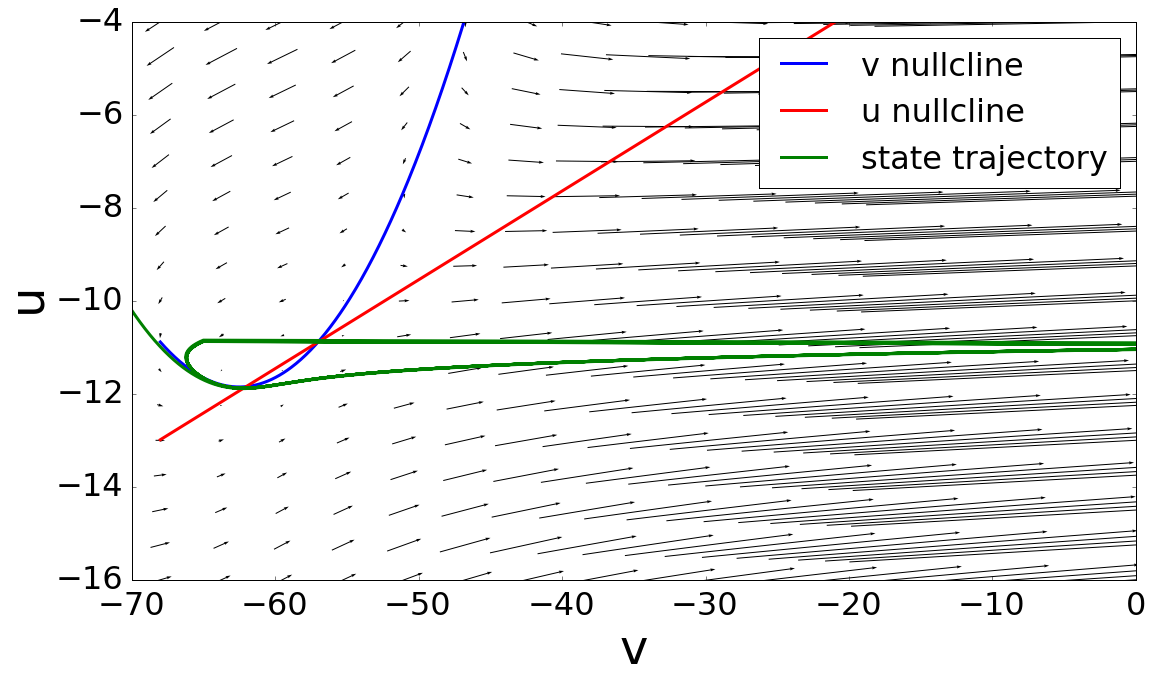

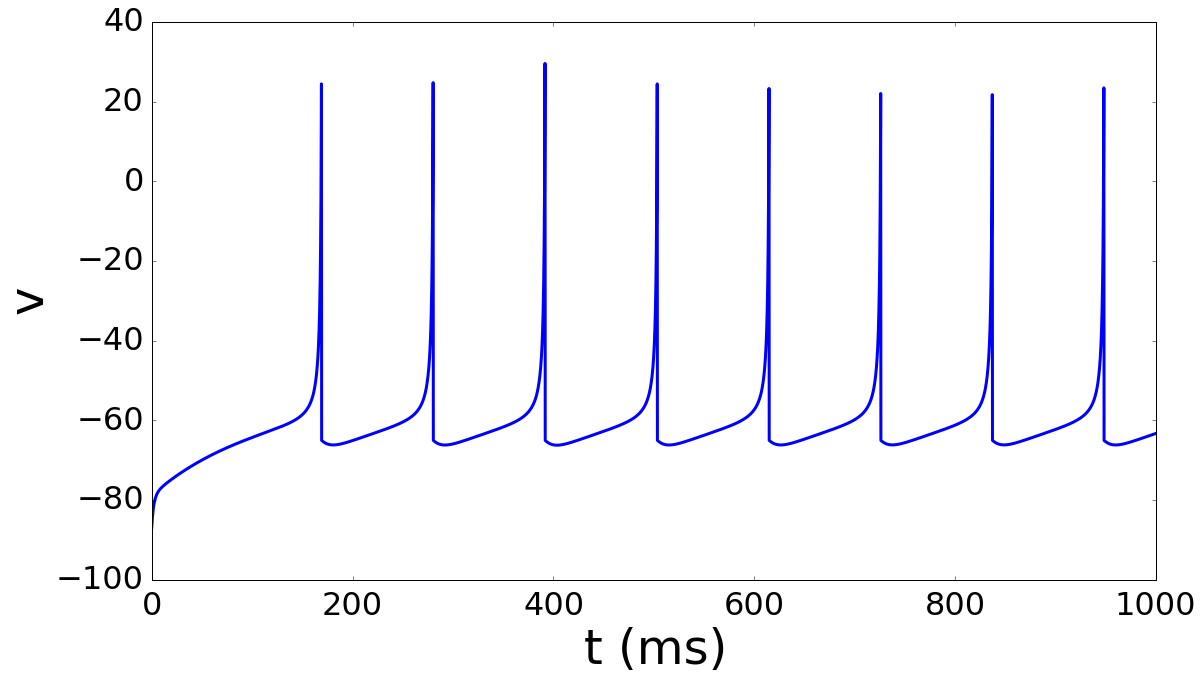

In [10]:
from IPython.html.widgets import interact

interact(run_ivscaled_model,
         expt=(0,10,1),
         lowerV=(-120,-40,1),
         upperV=(-40,60,1),
         qvloweru=(-20,16,1),
         qvupperu=(-6,10,1),
         qpspacing=(0,10,0.5), # vector spacing
         qpveclen=(10,300,10)) #vector length

## Explore IV scaled STN candidate model

In [11]:
# Modify and run Izhi_STN_IV
def explore_ivscaled_model (a=_a,b=_b,c=_c,d=_d,
                            k=_k,Ca=_Ca,vr=_vr,vt=_vt,SI=_SI,T=_T,vpeak=_vpeak,
                            vinit=_vinit,uinit=_uinit,
                            lowerV=-90, upperV=30, qvloweru=-20, qvupperu=0,
                            qpspacing=4, qpveclen=50, constI=0):

    import sys
    sys.path.append("../analysis")
    
    # Where's the model and data?
    modeldir = '/home/seb/izhibg/GPR_Izhikevich/Izhi_STN_IV';
    expt = 0;
    population = 'Sebtest2'
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemltmp = spineml2brahms+'/temp/log/';

    # Modify the model xml
    import update_iv_model_xml as ivupdate
    ivupdate.update_iv_model_xml (modeldir,expt,a,b,c,d,k,Ca,vr,vt,SI,T,vpeak,vinit,uinit)

    print 'params: abcd:', a, b, c, d, 'k,Ca,vr,vt:', k, Ca, vr, vt, ' SI,T:', SI,T, ' vpeak,vinit,uinit:', vpeak,vinit,uinit
  
    # Execute the model
    import os
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                 `expt`+' -c'+population+':I:'+`constI`+' ; popd"';
    os.system(spinemlcmd);

    # load the data from the model run
    import load_sc_data as lsd
    v, v_count, t, nn, dt = lsd.load_sc_data (spinemltmp+population+'_v_log.bin');
    u, u_count, tu, nnu, dtu = lsd.load_sc_data (spinemltmp+population+'_u_log.bin');

    import numpy as np
    
    # Compute nullclines
    Vn = np.linspace (lowerV, upperV, 1000);
    I = np.zeros(v_count)+constI;
    nc_v = k*(Vn-vr)*(Vn-vt) + b*vr + (I[:len(Vn)]/SI) ;
    nc_u = Vn*b;

    # Compute vector field
    if qpspacing != 0:
        thescale = abs(lowerV-upperV)/qpspacing;
        Vgv = np.linspace(lowerV, upperV, thescale);
        ugv = np.linspace(qvloweru, qvupperu, thescale);
        Vg, ug = np.meshgrid(Vgv, ugv);
        vdot = (T/Ca)*(k*(Vg-vr)*(Vg-vt) - ug + b*vr + I[:len(Vg)]/SI);
        udot = T*a*(b*Vg - ug);
    
    # Plot it.
    %matplotlib inline
    import plot_izhi as pizhi
    pizhi.plot_izhi ('STN candidate model IV form', v, u, Vn, nc_v, nc_u, Vg, ug, vdot, udot,
                     lowerV, upperV, qvloweru, qvupperu, qpspacing, qpveclen)

    # Now plot the time series
    import matplotlib.pyplot as plt
    plt.figure(figsize=(18,10))
    plt.clf;
    plt.plot (t, v)
    plt.xlabel('t (ms)')
    plt.ylabel('v') 


params: abcd: 0.0223 0.191 -65 0.05 k,Ca,vr,vt: 0.032 2.5 -57.01245 -67.98755  SI,T: 7.5 4.1  vpeak,vinit,uinit: 30 -70.0 -10.0


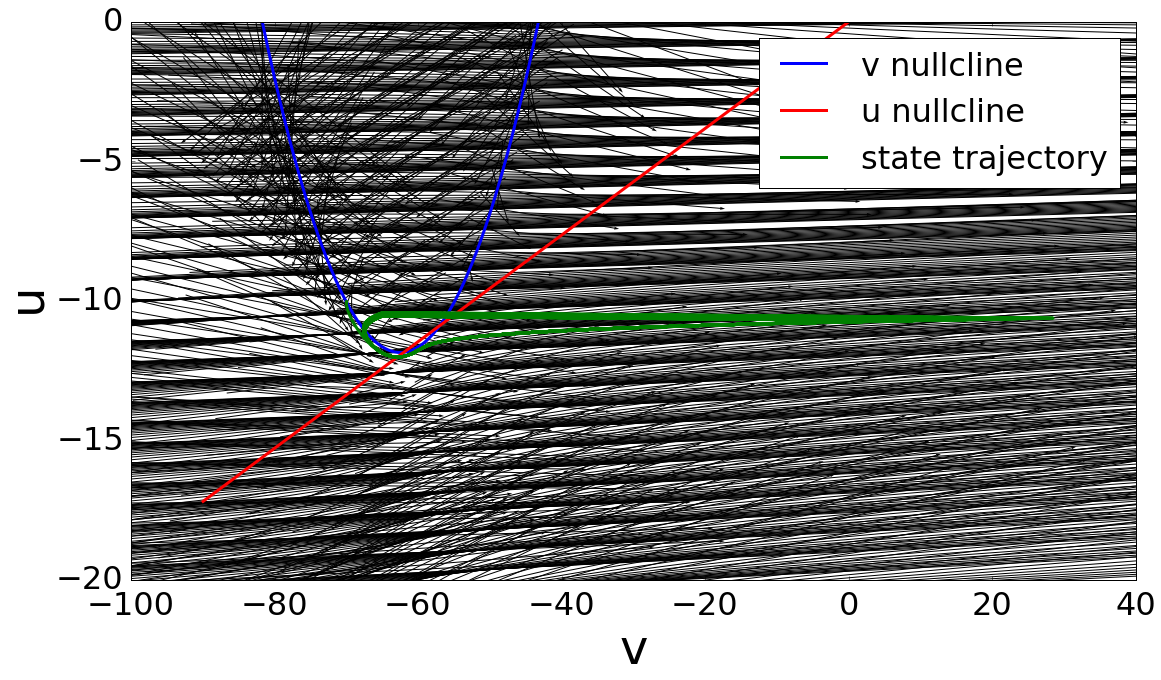

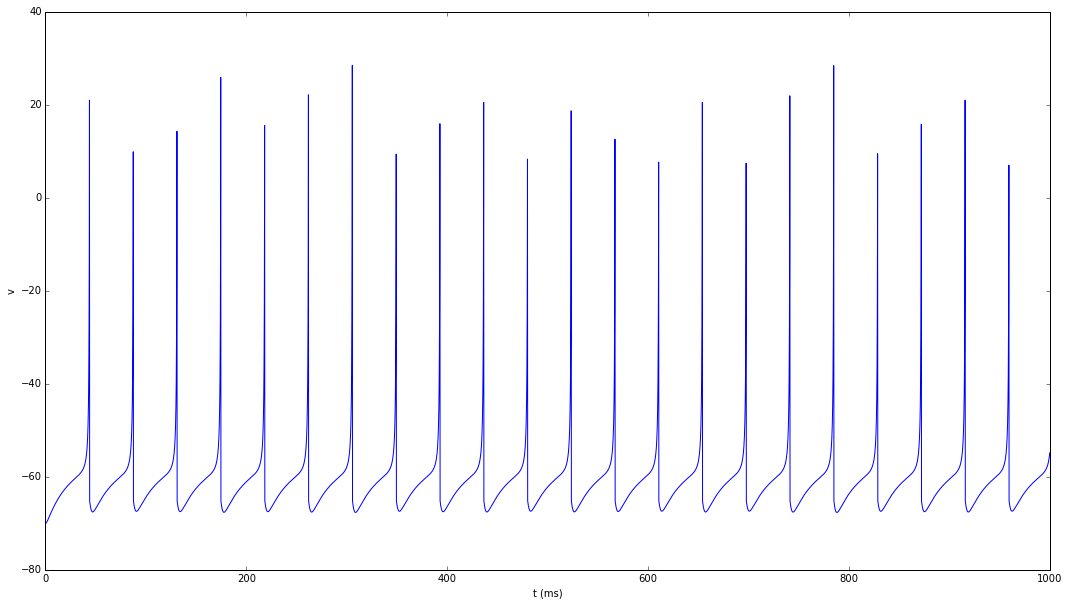

In [12]:
from IPython.html.widgets import interact

interact(explore_ivscaled_model,
         constI=(-100,100,0.5),
         a=(0.02,0.035,0.0001),
         b=(0.100,0.300,0.001),
         c=(-120,30,1),
         d=(0,0.5,0.01),
         T=(0.0,10.0,0.1),
         SI=(0.0,10,0.1),
         k=(0.03,0.035,0.0001),
         Ca=(1,10,0.01),
         vr=(-100,0,0.01),
         vt=(-100,0,0.01),
         vpeak=(20,40,1),
         lowerV=(-120,-40,1),
         upperV=(-40,60,1),
         qvloweru=(-20,0,1),
         qvupperu=(-6,10,1),
         qpscale=(0,6,0.1),
         qpdivisor=(0.00001,0.0001,0.00001),
         vinit=(-120,30,.1),
         uinit=(-20,10,.1));


## Firing rate vs current for IV model

In [13]:
# Do a sweep through the currents with a given set of parameters.
def iv_rate_sweep (constIlist):
    import sys
    sys.path.append("../analysis")
    
    # Set your parameters here...
    a=_a; b=_b; c=_c; d=_d
    vpeak=_vpeak;
    k=_k; Ca=_Ca; vr=_vr; vt=_vt; T=_T; SI=_SI;
    lowerV=-80; upperV=-20; qvloweru=-16; qvupperu=-10
    qpscale=3; qpdivisor=0.00001;
    vinit=_vinit; uinit=_uinit
    # Where's the model and data?
    modeldir = '/home/seb/izhibg/GPR_Izhikevich/Izhi_STN_IV';
    expt = 0;
    population="Sebtest2"
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemltmp = spineml2brahms+'/temp/log/';

    # Modify the model xml
    import update_iv_model_xml as ivupdate
    ivupdate.update_iv_model_xml (modeldir,expt,a,b,c,d,k,Ca,vr,vt,SI,T,vpeak,vinit,uinit)

    # Execute the model
    import os
    import load_sc_data as lsd
    import firing_rate as fr

    # Put this in a loop, and do some analysis to extract the firing rate from the output.
    rates=[];
    isiRates=[];
    for constI in constIlist:
        spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+`expt`+' -c'+population+':I:'+`constI`+' ; popd"';
        os.system(spinemlcmd);

        # load the data from the model run
        v, v_count, t, nn, dt = lsd.load_sc_data (spinemltmp+population+'_v_log.bin');
        u, u_count, tu, nn, dt = lsd.load_sc_data (spinemltmp+population+'_u_log.bin');
    
        rate, isiRate = fr.firing_rate (v, t[len(t)-1], 0.1)
        print 'rate:', rate, ' isiRate:', isiRate
        rates.append(rate);
        isiRates.append(isiRate);

    return rates, isiRates


rate: 5.00050005001  isiRate: 5.63761416169
rate: 6.00060006001  isiRate: 6.24869818788
rate: 7.00070007001  isiRate: 7.02881815443
rate: 8.00080008001  isiRate: 8.87705281846
rate: 13.00130013  isiRate: 13.1260096931
rate: 29.00290029  isiRate: 29.9370290079
rate: 76.0076007601  isiRate: 76.6747376917
rate: 186.01860186  isiRate: 190.048022888
rate: 286.02860286  isiRate: 294.693456981


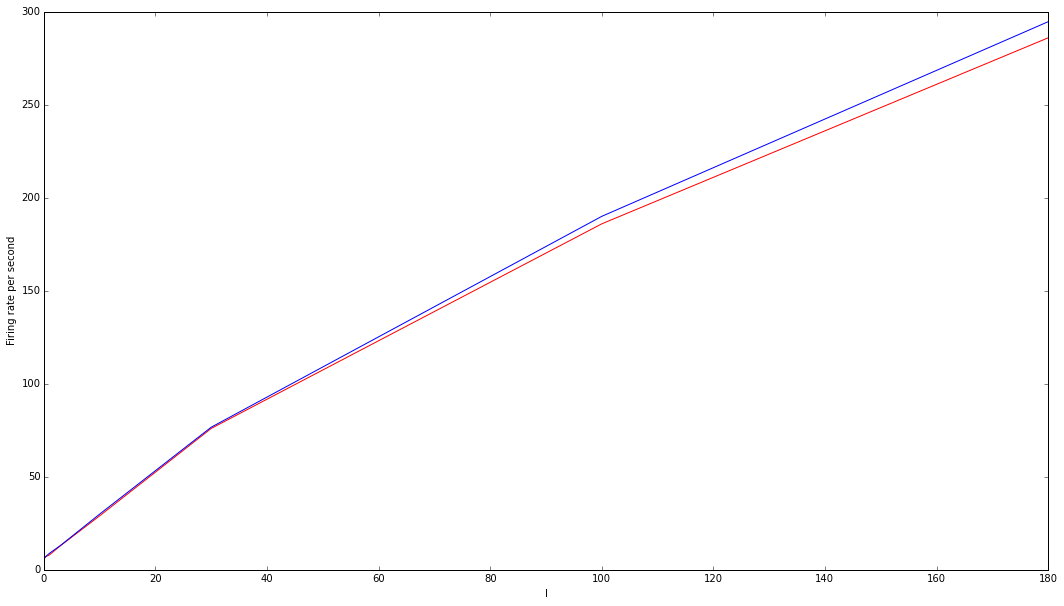

In [14]:
constIlist = [0, 0.1, 0.3, 1, 3, 10, 30, 100, 180]
rates, isiRates = iv_rate_sweep(constIlist)
#%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(18,10))
plt.clf;
plt.plot (constIlist, rates, color='r')
plt.plot (constIlist, isiRates, color='b')
plt.xlabel('I')
plt.ylabel('Firing rate per second')

## June 11th conclusion

There doesn't appear to be a great deal to be gained by working with the I-V formulation of the model, I think I prefer the ABC form. If I scale the current by a factor of 5, I can get quite a nice current vs. firing rate graph. I'll add the ABC stuff into this notebook tomorrow.

# ABCT model for STN
## 12th June. Running the STN ABCT model
This notebook shows how to run the STN candidate ABC model. There's "define_and_run_model" which allows you to push in the parameters of the model before running it. There's run_model() which runs and visualises a model without modifying it. There's also a section on finding the firing rates vs. current.

### Model definition

$${\dot{v}\over T}=Av^2+Bv+C-u+{I\over S_I}$$
$${\dot{u}\over T}=a(bv-u)$$
$$v>v_{peak}: v\leftarrow c, u \leftarrow u+d$$

###Model parameters
The parameters for the model are in the code block below:

In [17]:
# Here are the STN model parameters
_a=0.03; _b=0.193; _c=-59; _d=0.05;
_vpeak=30; _A=0.032; _B=4; _C=113.147; _T=0.4; _SI=20;
_vinit=-70; _uinit=-10;

In [18]:
# Compute parameters for IzhiABCTFast component:
AT=_A*_T
BT=_B*_T
CT=_C*_T
aT=float(_a)*_T
ToverSI=float(_T)/_SI
print 'aT=',aT,'b=',_b,'c=',_c,'d=',_d
print 'AT=',AT,'BT=',BT,'CT=',CT,'T=',_T,'ToverSI=',ToverSI

aT= 0.012 b= 0.193 c= -59 d= 0.05
AT= 0.0128 BT= 1.6 CT= 45.2588 T= 0.4 ToverSI= 0.02


## Modify then run and visualise an ABCT model

This code will define parameters in the SpineML model description, then run and visualise that model. If run with default parameters, then it will show the model with parameters as defined above (_a, _b, etc).

In [19]:
# *Modify* the model then run it and finally analyse it.
def explore_abc_model (constI=0, a=_a, b=_b, c=_c, d=_d, 
                       vpeak=_vpeak, A=_A, B=_B, C=_C, T=_T, SI=_SI,
                       lowerV=-80, upperV=-20, qvloweru=-16, qvupperu=-10, 
                       qpspacing=3, qpveclen=60, vinit=_vinit, uinit=_uinit):

    import sys
    sys.path.append("../analysis")

    # Where's the model and data?
    modeldir = '/home/seb/izhibg/GPR_Izhikevich/Izhi_STN';
    expt = 0;
    population = 'Sebtest1'
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemltmp = spineml2brahms+'/temp/log/';

    # Modify the model xml
    import update_abc_model_xml as abcupdate
    abcupdate.update_abc_model_xml (modeldir,expt,a,b,c,d,A,B,C,T,SI,vpeak,vinit,uinit)

    # Execute the model
    import os
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                 `expt`+' -c'+population+':I:'+`constI`+' ; popd"';
    os.system(spinemlcmd);

    # load the data from the model run
    import load_sc_data as lsd
    v, v_count, t, nn, dt = lsd.load_sc_data (spinemltmp+population+'_v_log.bin');
    u, u_count, tu, nnu, dtu = lsd.load_sc_data (spinemltmp+population+'_u_log.bin');

    import numpy as np

    # Compute nullclines
    I = np.zeros(v_count)+constI;
    Vn = np.linspace (lowerV, upperV, 1000);
    nc_v = A*np.power(Vn, 2)+ B*Vn + C + I[:len(Vn)]/SI;
    nc_u = Vn*b;

    # Compute vector field
    if qpspacing != 0:
        thescale = abs(lowerV-upperV)/qpspacing;
        Vgv = np.linspace(lowerV, upperV, thescale);
        ugv = np.linspace(qvloweru, qvupperu, thescale);
        Vg, ug = np.meshgrid(Vgv, ugv);
        vdot = T*A*Vg*Vg + T*B*Vg + T*C - T*ug + T*I[:len(Vg)]/SI;
        udot = T*a*(b*Vg - ug);
    
    # Plot it.
    %matplotlib inline
    import plot_izhi as pizhi
    pizhi.plot_izhi ('STN candidate model', v, u, Vn, nc_v, nc_u, Vg, ug, vdot, udot,
                     lowerV, upperV, qvloweru, qvupperu, qpspacing, qpveclen)
    
    # Now plot the time series
    import matplotlib.pyplot as plt
    plt.figure(figsize=(18,10))
    plt.clf;
    plt.plot (t, v)
    plt.xlabel('t (ms)')
    plt.ylabel('v') 

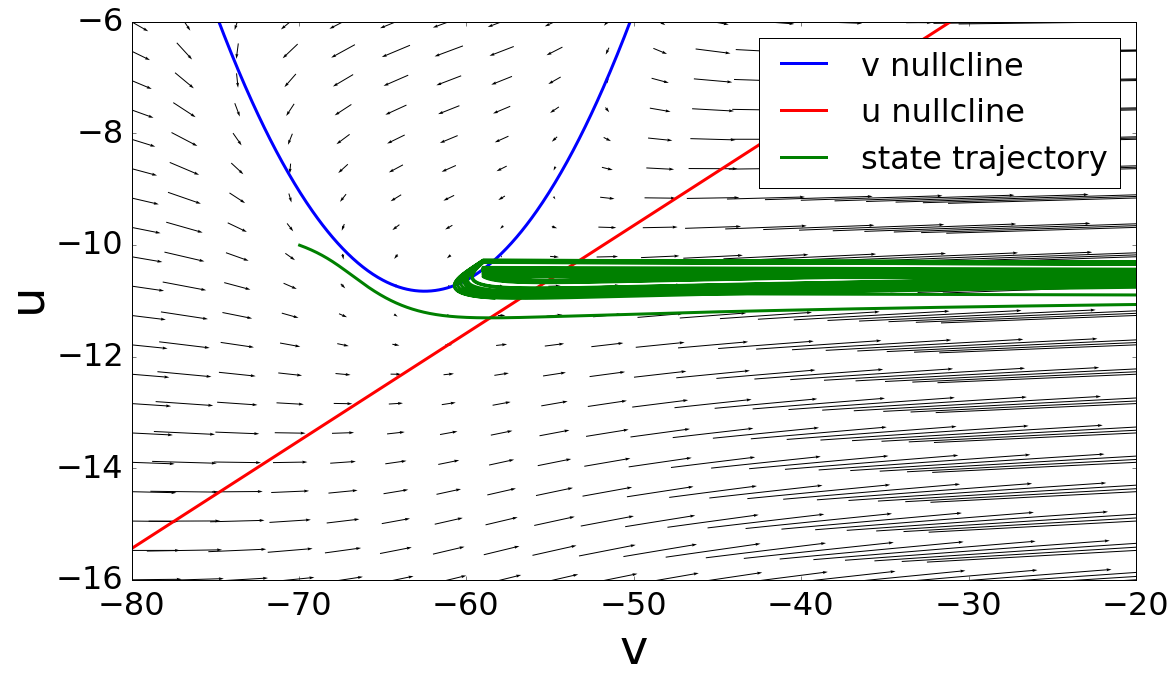

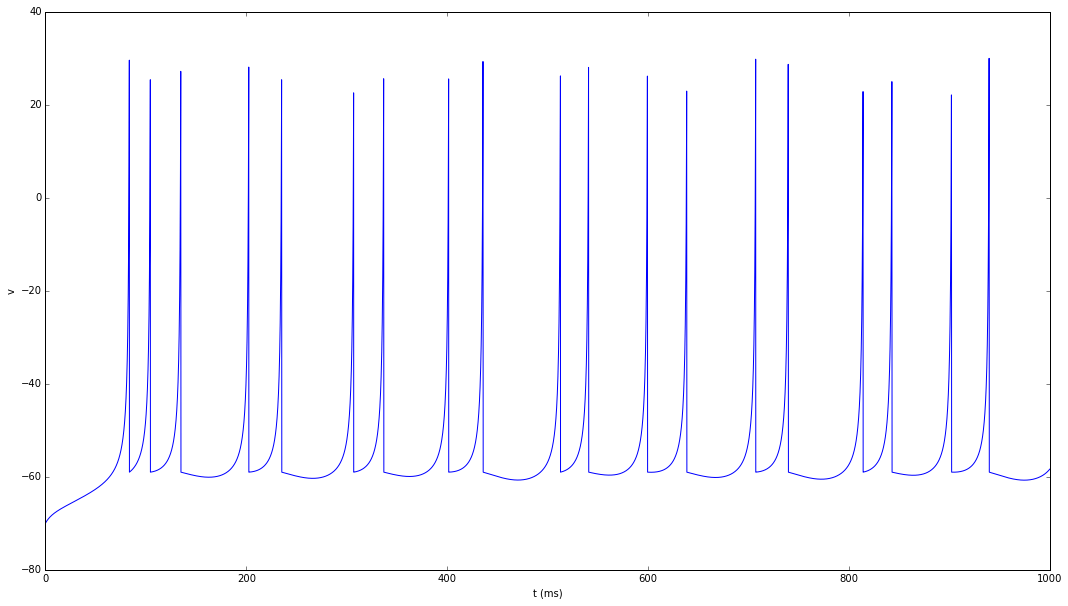

In [20]:
from IPython.html.widgets import interact

interact(explore_abc_model,
         vpeak=(20,40,1),
         lowerV=(-120,-40,1),
         upperV=(-40,60,1),
         qvloweru=(-20,0,1),
         qvupperu=(-6,10,1),
         qpscale=(0,6,0.1),
         qpdivisor=(0.00001,0.0001,0.00001),
         constI=(-100,100,0.5),
         a=(0.02,0.035,0.0001),
         b=(0.100,0.300,0.001),
         c=(-120,30,1),
         d=(-1,5,0.01),
         T=(0.0,10.0,0.1),
         A=(0.03,0.035,0.0001),
         B=(3,5,0.01),
         C=(100,150,0.1),
         vinit=(-120,30,.1),
         uinit=(-20,10,.1));

## Read, run and visualise an ABCT model

In [22]:
# *Read* the model then run it and finally analyse it.
def run_abc_model (expt=0, lowerV=-80, upperV=-20, qvloweru=-16, qvupperu=-10,
                   qpspacing=3, qpveclen=70):

    # Where's the model and data?
    modeldir = '/home/seb/izhibg/GPR_Izhikevich/Izhi_STN';
    population = 'Sebtest1';
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemltmp = spineml2brahms+'/temp/log/';

    # Modify the model xml
    import read_abc_model_xml as abcread
    a,b,c,d,A,B,C,T,vpeak,vinit,uinit = abcread.read_abc_model_xml (modeldir,expt)
    
    # Execute the model
    import os
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                 `expt`+' ; popd"'; # omit: +' -c'+population+':I:'+`constI`
    os.system(spinemlcmd);

    # load the data from the model run
    import load_sc_data as lsd
    v, v_count, t, nn, dt = lsd.load_sc_data (spinemltmp+population+'_v_log.bin');
    u, u_count, tu, nnu, dtu = lsd.load_sc_data (spinemltmp+population+'_u_log.bin');

    import numpy as np

    # Temporary hack - better to get this from xml
    constI = 0
    
    # Compute nullclines
    Vn = np.linspace (lowerV, upperV, 1000);
    I = np.zeros(v_count)+constI;
    nc_v = A*np.power(Vn, 2)+ B*Vn + C + I[:len(Vn)];
    nc_u = Vn*b;

    # Compute vector field
    if qpspacing != 0:
        thescale = abs(lowerV-upperV)/qpspacing;
        Vgv = np.linspace(lowerV, upperV, thescale);
        ugv = np.linspace(qvloweru, qvupperu, thescale);
        Vg, ug = np.meshgrid(Vgv, ugv);
        vdot = T*A*Vg*Vg + T*B*Vg + T*C - T*ug + T*I[:len(Vg)];
        udot = T*a*(b*Vg - ug);
    
    # Plot it.
    %matplotlib inline
    import plot_izhi as pizhi
    pizhi.plot_izhi ('STN candidate model', v, u, Vn, nc_v, nc_u, Vg, ug, vdot, udot,
                     lowerV, upperV, qvloweru, qvupperu, qpspacing, qpveclen)
    
    # Now plot the time series
    import matplotlib.pyplot as plt
    plt.figure(figsize=(18,10))
    plt.clf;
    plt.plot (t, v)
    plt.xlabel('t (ms)')
    plt.ylabel('v') 

The following experiments show some of the features required of the STN model. Rebound bursting (ref?). After-hyperpolarisation (ref?).

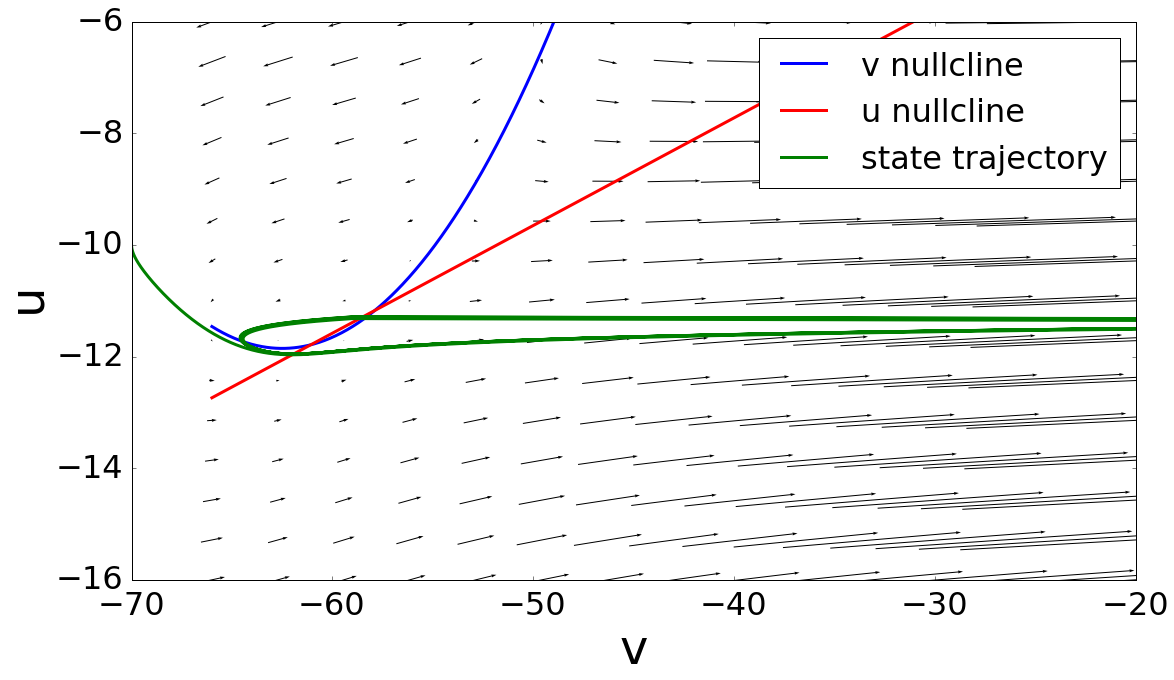

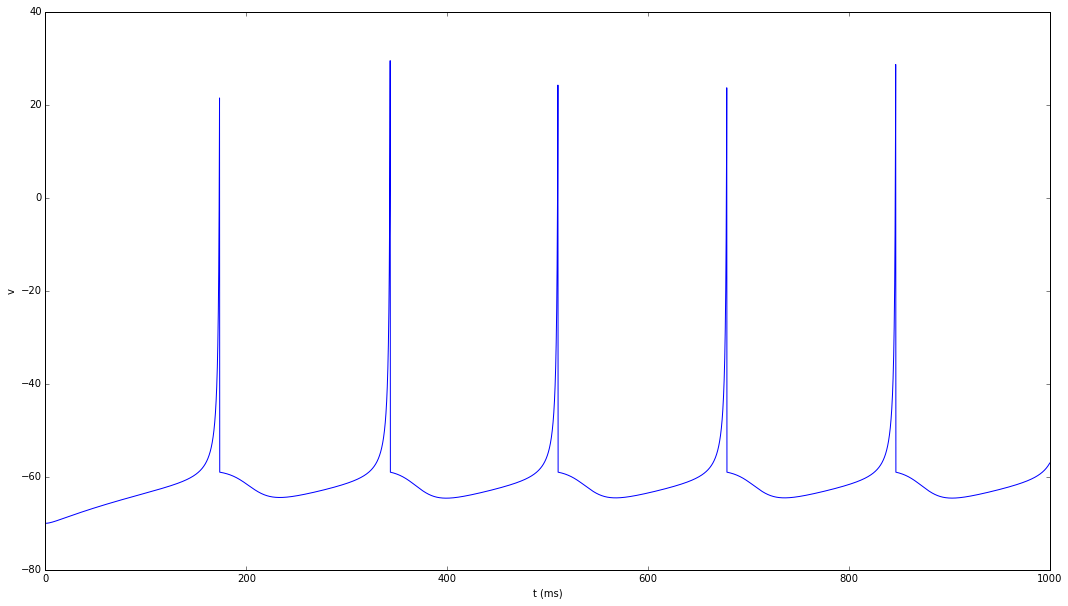

In [23]:
from IPython.html.widgets import interact

interact(run_abc_model,
         expt=(0,10,1),
         lowerV=(-120,-40,1),
         upperV=(-40,60,1),
         qvloweru=(-20,0,1),
         qvupperu=(-6,10,1),
         qpspacing=(0,10,0.5),
         qpveclen=(10,300,10))

## Produce firing rate vs. current for ABCT model

In [24]:
# Do a sweep through the currents with a given set of parameters.
def abc_rate_sweep (constIlist):
    # Set your parameters here...
    expt = 0;
    a=_a; b=_b; c=_c; d=_d
    vpeak=_vpeak;
    A=_A; B=_B; C=_C; T=_T; SI=_SI;
    lowerV=-80; upperV=-20; qvloweru=-16; qvupperu=-10
    qpscale=3; qpdivisor=0.00001;
    vinit=_vinit; uinit=_uinit
    # Where's the model and data?
    modeldir = '/home/seb/izhibg/GPR_Izhikevich/Izhi_STN';
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemltmp = spineml2brahms+'/temp/log/';

    # Modify the model xml
    import update_abc_model_xml as abcupdate
    abcupdate.update_abc_model_xml (modeldir,expt,a,b,c,d,A,B,C,T,SI,vpeak,vinit,uinit)

    # Execute the model
    import os
    import load_sc_data as lsd
    import firing_rate as fr

    # Put this in a loop, and do some analysis to extract the firing rate from the output.
    rates=[];
    isiRates=[];
    for constI in constIlist:
        spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+`expt`+' -cSebtest1:I:'+`constI`+' ; popd"';
        os.system(spinemlcmd);

        # load the data from the model run
        v, v_count, t, nn, dt = lsd.load_sc_data (spinemltmp+'Sebtest1_v_log.bin');
        u, u_count, tu, nnu, dtu = lsd.load_sc_data (spinemltmp+'Sebtest1_u_log.bin');
    
        rate, isiRate = fr.firing_rate (v, t[len(t)-1], 0.1)
        print 'rate:', rate, ' isiRate:', isiRate
        rates.append(rate);
        isiRates.append(isiRate);

    return rates, isiRates


rate: 5.00050005001  isiRate: 5.66764905917
rate: 5.00050005001  isiRate: 5.69995440036
rate: 5.00050005001  isiRate: 5.75109270761
rate: 5.00050005001  isiRate: 5.90946696608
rate: 6.00060006001  isiRate: 6.08210846427
rate: 12.00120012  isiRate: 13.5654533122
rate: 30.0030003  isiRate: 30.2175664786
rate: 86.0086008601  isiRate: 87.2210953347
rate: 130.0130013  isiRate: 131.699846861
rate: 162.01620162  isiRate: 165.508786269
rate: 183.01830183  isiRate: 186.810943242
rate: 219.02190219  isiRate: 224.500256279
rate: 253.02530253  isiRate: 259.552992069


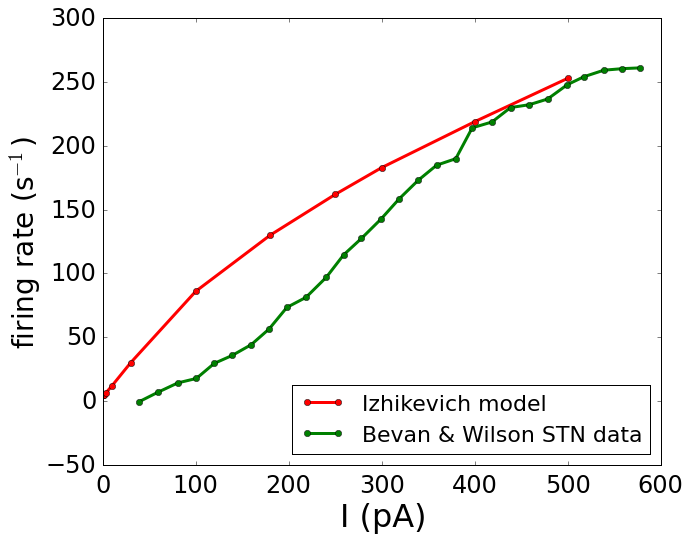

In [25]:
constIlist = [0, 0.1, 0.3, 1, 3, 10, 30, 100, 180, 250, 300, 400, 500]
rates, isiRates = abc_rate_sweep(constIlist)
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.clf;

#plt.plot (constIlist, rates, color='r',linewidth=4)
#plt.plot (constIlist, isiRates, color='b')
# Load BevanWilson data.
#BW = np.loadtxt(open("./published_data/STN/Bevan_Wilson_Fig_6b.csv","rb"),delimiter=",",skiprows=1)
#plt.plot (BW[:,0], BW[:,1], marker='o', color='g', linewidth=4)
#plt.xlabel('I')
#plt.ylabel('Firing rate per second')

plt.plot (constIlist, rates, color='r', marker='o', label='Izhikevich model',linewidth=3)
#plt.plot (constIlist, isiRates, color='b')
# Load BevanWilson data.
import numpy as np
BW = np.loadtxt(open("./published_data/STN/Bevan_Wilson_Fig_6b.csv","rb"),delimiter=",",skiprows=1)
plt.plot (BW[:,0], BW[:,1], marker='o', color='g', label='Bevan & Wilson STN data',linewidth=3)
plt.xlabel('I',fontsize=32)
plt.ylabel('Firing rate per second',fontsize=32)
#plt.title('STN ABCTSigI model f-I curve',fontsize=28,y=1.05)
plt.xlabel('I (pA)',fontsize=32)
plt.ylabel('firing rate (s$^{-1}$)',fontsize=28)
plt.tick_params(axis='x', labelsize=24, pad=8)
plt.tick_params(axis='y', labelsize=24, pad=8)
plt.legend(loc=4,fontsize=22)
plt.savefig('/home/seb/izhibg/GPR_Izhikevich/labbook/STN_IzhiBasic_f-I.svg')
plt.show()

### Read current state of Izhi_STN model

In [26]:
modeldir = '/home/seb/izhibg/GPR_Izhikevich/Izhi_STN';
expt = 0;
import read_abc_model_xml as abcread
a,b,c,d,A,B,C,T,vpeak,vinit,uinit = abcread.read_abc_model_xml (modeldir,expt)
print ('Current Izhi STN model parameters')
print ('---------------------------------')
print ('a={0} b={1} c={2}, d={3}'.format(a,b,c,d))
print ('A={0} B={1} C={2}'.format(A,B,C))
print ('T={0} vpeak={1} vinit={2} uinit={3}'.format(T,vpeak,vinit,uinit))
print ('\n(as read from {0})'.format(modeldir))

Current Izhi STN model parameters
---------------------------------
a=0.03 b=0.193 c=-59.0, d=0.05
A=0.032 B=4.0 C=113.147
T=0.4 vpeak=30.0 vinit=-70.0 uinit=-10.0

(as read from /home/seb/izhibg/GPR_Izhikevich/Izhi_STN)


# ABCTSigI STN Model
## Sigmoidal firing rate vs I
Bevan and Wilson, in "Mechanisms Underlying Spontaneous Oscillation and Rhythmic Firing in Rat Subthalamic Neurons", 1999, report that the f-I curve is sigmoidal for STN neurons. It may be necessary to have a vector of 'u's to get the right f-I behaviour. Note that the f-I curve results from the experimental manipulation of injecting current, and may be different in character from an f-f curve, which compares afferent and efferent population firing rates.

Replace I with $I_{sig}(I)$, where $I_{sig}(I)$ is
$$I_{sig} = {I_{max}\over 1 + e^{-k(I-I_0)}} - {I_{max}\over 1 + e^{-k(0-I_0)}}$$
Where I is always positive. I is passed in unmodified if I<0. The second term ensures that $I_{sig}(0) = 0$

In [27]:
import numpy as np

# Here are the STN model parameters again, updated for the Sigmoidal I ABCT model
_a=0.03; _b=0.193; _c=-65; _d=0.05;
_vpeak=30; _A=0.032; _B=4; _C=113.147; _T=0.4; _SI=20;
_vinit=-70; _uinit=-10;
# Along with conversion to ABCTFast style:
# Compute parameters for IzhiABCTFast component:
AT=_A*_T
BT=_B*_T
CT=_C*_T
aT=float(_a)*_T
ToverSI=float(_T)/_SI

# Plus the new sigmoid parameters:
_k = 0.014
_I0=300
_Imax=600

# Default experiment
_expt = 0

# Ioff is the offset so that the sigmoid approaches 0 for 0 current.
Ioff = _Imax/(1+np.exp(_k*_I0))

print 'aT=',aT,'b=',_b,'c=',_c,'d=',_d
print 'AT=',AT,'BT=',BT,'CT=',CT,'T=',_T,'ToverSI=',ToverSI,'Ioff=',Ioff
print 'k=',_k,'I0=',_I0,'Imax=',_Imax

aT= 0.012 b= 0.193 c= -65 d= 0.05
AT= 0.0128 BT= 1.6 CT= 45.2588 T= 0.4 ToverSI= 0.02 Ioff= 8.86441901596
k= 0.014 I0= 300 Imax= 600


### Modify/explore Izhi_STNPlus model

NB: If you run this, then afterwards, check if you need to:

```git co -- Izhi_STNPlus/model.xml ```

In [28]:
# *Modify* a modified Izhikevich model then run it and finally analyse it.
def explore_abctsigi_model (expt = _expt, constI=0, a=_a, b=_b, c=_c, d=_d, 
                           vpeak=_vpeak, A=_A, B=_B, C=_C, T=_T, SI=_SI,
                           lowerV=-80, upperV=-20, qvloweru=-16, qvupperu=-10, 
                           qpspacing=3, qpveclen=60, vinit=_vinit, uinit=_uinit):

    import sys
    sys.path.append("../analysis")

    # Where's the model and data?
    modeldir = '/home/seb/izhibg/GPR_Izhikevich/Izhi_STNPlus';
    population = 'Sebtest1'
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemltmp = spineml2brahms+'/temp/log/';

    # Modify the model xml
    import update_abc_model_xml as abcupdate
    abcupdate.update_abc_model_xml (modeldir,expt,a,b,c,d,A,B,C,T,SI,vpeak,vinit,uinit)

    # Execute the model
    import os
    if constI == 0:
        # If current set to 0, then don't modify current from experiment.
        spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                     'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                     `expt`+' ; popd"';
    else:
        spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                     'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                     `expt`+' -c'+population+':I:'+`constI`+' ; popd"';
    os.system(spinemlcmd);

    # load the data from the model run
    import load_sc_data as lsd
    v, v_count, t, nn, dt = lsd.load_sc_data (spinemltmp+population+'_v_log.bin');
    u, u_count, tu, nnu, dtu = lsd.load_sc_data (spinemltmp+population+'_u_log.bin');

    #print type(v) # list
    #print type(t) # ndarray
    
    import numpy as np

    # Compute nullclines
    I = np.zeros(v_count)+constI;
    Vn = np.linspace (lowerV, upperV, 1000);
    nc_v = A*np.power(Vn, 2)+ B*Vn + C + I[:len(Vn)]/SI;
    nc_u = Vn*b;

    # Compute vector field
    if qpspacing != 0:
        thescale = abs(lowerV-upperV)/qpspacing;
        Vgv = np.linspace(lowerV, upperV, thescale);
        ugv = np.linspace(qvloweru, qvupperu, thescale);
        Vg, ug = np.meshgrid(Vgv, ugv);
        vdot = T*A*Vg*Vg + T*B*Vg + T*C - T*ug + T*I[:len(Vg)]/SI;
        udot = T*a*(b*Vg - ug);
    
    # Plot it. comment out inline thing for standalone graphs
    %matplotlib inline
    import plot_izhi as pizhi
    pizhi.plot_izhi ('STN ABCTSigI model phase plot', v, u, Vn, nc_v, nc_u, Vg, ug, vdot, udot,
                     lowerV, upperV, qvloweru, qvupperu, qpspacing, qpveclen)
    
    # Now plot the time series
    import matplotlib.pyplot as plt
    plt.figure(figsize=(18,10))
    plt.clf;
    plt.plot (t, v, linewidth=4)
    ax = plt.gca()
    #ax.axhline(linewidth=4)
    #ax.axvline(linewidth=4)
    
    #plt.title('STN ABCTSigI model spikes',fontsize=48,y=1.05)
    plt.xlabel('t (ms)',fontsize=48)
    plt.ylabel('v',fontsize=48)
    plt.tick_params(axis='x', labelsize=32, pad=10)
    plt.tick_params(axis='y', labelsize=32, pad=10)
    plt.savefig('/home/seb/izhibg/GPR_Izhikevich/labbook/STN_ABCTSigI_tseries.svg')
    plt.show()
    
    # Finally write out csv file for graphing the results externally
    ofile = '{0}/{1}_STN_ABCTSigI_v_t.csv'.format(spinemltmp,population)
    fo = open(ofile, 'w')
    fo.write('t,v\n')
    i = 0
    for v_ in v:
        fo.write('{0},{1}\n'.format(t[i],v_))
        i=i+1

    fo.close()


### Call the modify/explore code on Izhi_STNPlus

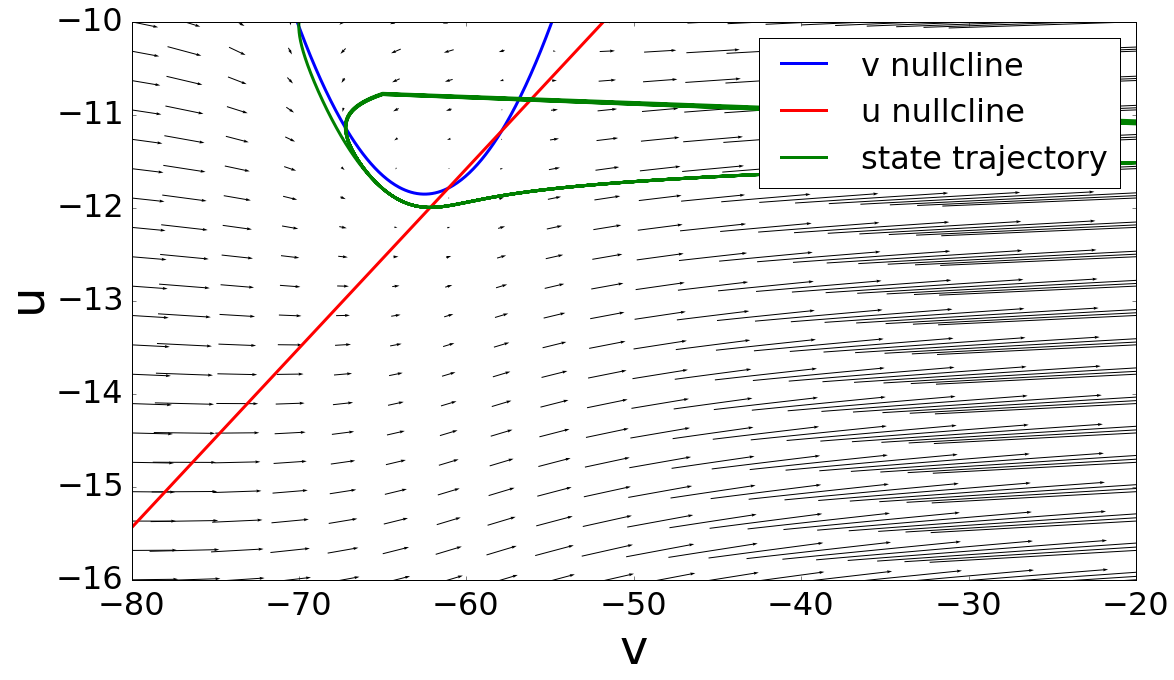

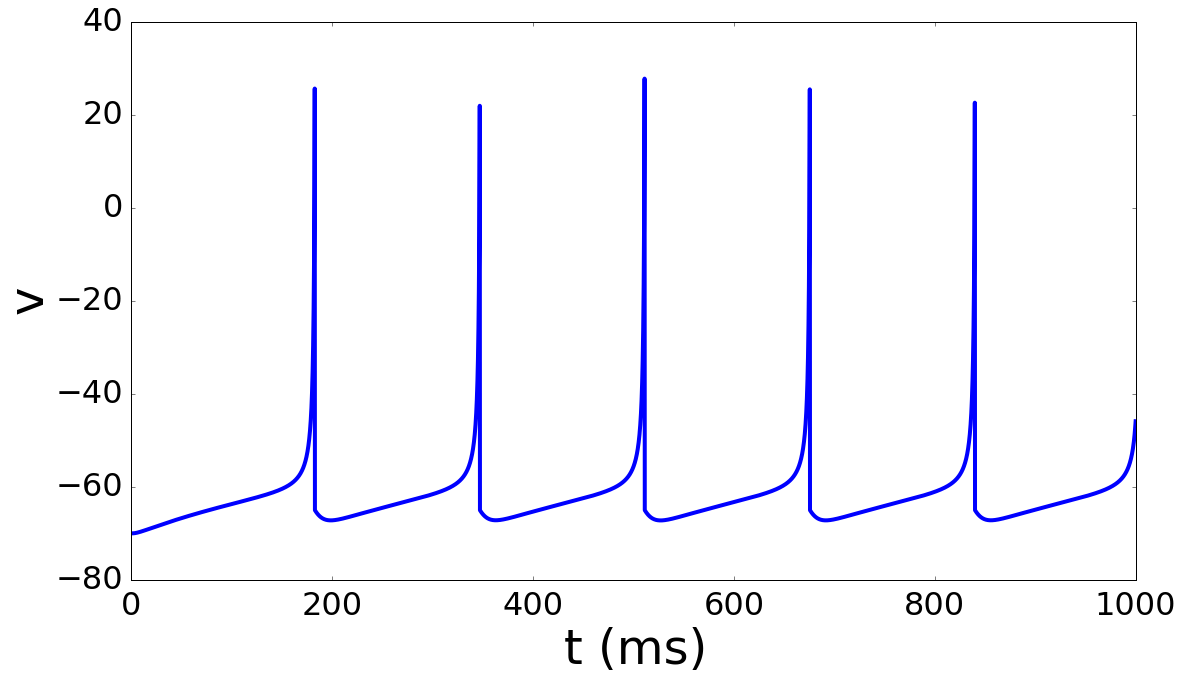

In [29]:
from IPython.html.widgets import interact

_expt = 0

interact(explore_abctsigi_model,
         expt=(0,10,1),
         vpeak=(20,40,1),
         constI=(-100,100,0.5),
         a=(0.02,0.035,0.0001),
         b=(0.100,0.300,0.001),
         c=(-120,30,1),
         d=(-1,5,0.01),
         T=(0.0,10.0,0.1),
         A=(0.03,0.035,0.0001),
         B=(3,5,0.01),
         C=(100,150,0.1),
         vinit=(-120,30,.1),
         uinit=(-20,10,.1));

#lowerV=(-120,-40,1),
#         upperV=(-40,60,1),
#         qvloweru=(-20,0,1),
#         qvupperu=(-6,10,1),
#         qpscale=(0,6,0.1),
#         qpdivisor=(0.00001,0.0001,0.00001),

## abcplus_rate_sweep
### Sweep through the Izhi_STNPlus model
This function will run the Izhi_STNPlus model for all the currents provided in constIlist.

In [30]:
# Do a sweep through the currents with a given set of parameters.
def abcplus_rate_sweep (constIlist):
    # Set your parameters here...
    expt = 0;
    a=_a; b=_b; c=_c; d=_d
    vpeak=_vpeak;
    A=_A; B=_B; C=_C; T=_T; SI=_SI;
    k=_k; I0=_I0; Imax=_Imax;
    lowerV=-80; upperV=-20; qvloweru=-16; qvupperu=-10
    qpscale=3; qpdivisor=0.00001;
    vinit=_vinit; uinit=_uinit
    # Where's the model and data?
    modeldir = '/home/seb/izhibg/GPR_Izhikevich/Izhi_STNPlus';
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemltmp = spineml2brahms+'/temp/log/';
    
    import sys
    sys.path.append("../analysis")
    
    # Modify the model xml
    import update_abc_model_xml as abcupdate
    abcupdate.update_abcsig_model_xml (modeldir,expt,a,b,c,d,A,B,C,T,SI,k,I0,Imax,vpeak,vinit,uinit)

    # Execute the model
    import os
    import load_sc_data as lsd
    import firing_rate as fr

    # Put this in a loop, and do some analysis to extract the firing rate from the output.
    rates=[];
    isiRates=[];
    for constI in constIlist:
        spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+`expt`+' -cSebtest1:I:'+`constI`+' ; popd"';
        print 'run spineml model...'
        os.system(spinemlcmd);

        # load the data from the model run
        v, v_count, t, nn, dt = lsd.load_sc_data (spinemltmp+'Sebtest1_v_log.bin');
        u, u_count, tu, nnu, dtu = lsd.load_sc_data (spinemltmp+'Sebtest1_u_log.bin');
    
        rate, isiRate = fr.firing_rate (v, t[len(t)-1], 0.1)
        print 'rate:', rate, ' isiRate:', isiRate
        rates.append(rate);
        isiRates.append(isiRate);

    return rates, isiRates


### Call abc_plus_rate_sweep & visualise Izhi_STNPlus model

run spineml model...
rate: 6.00060006001  isiRate: 6.5970313359
run spineml model...
rate: 7.00070007001  isiRate: 7.30841511798
run spineml model...
rate: 8.00080008001  isiRate: 8.08897876643
run spineml model...
rate: 11.00110011  isiRate: 11.0943015633
run spineml model...
rate: 20.0020002  isiRate: 20.9533787323
run spineml model...
rate: 40.0040004  isiRate: 40.7083248524
run spineml model...
rate: 70.0070007001  isiRate: 71.3921468638
run spineml model...
rate: 108.01080108  isiRate: 109.67807454
run spineml model...
rate: 148.01480148  isiRate: 150.574829586
run spineml model...
rate: 183.01830183  isiRate: 186.84909128
run spineml model...
rate: 209.02090209  isiRate: 214.336991078
run spineml model...
rate: 228.02280228  isiRate: 233.630494928
run spineml model...
rate: 234.02340234  isiRate: 240.246406571
run spineml model...
rate: 245.02450245  isiRate: 251.158003088
run spineml model...
rate: 6.00060006001  isiRate: 6.5970313359
run spineml model...
rate: 7.00070007001  is

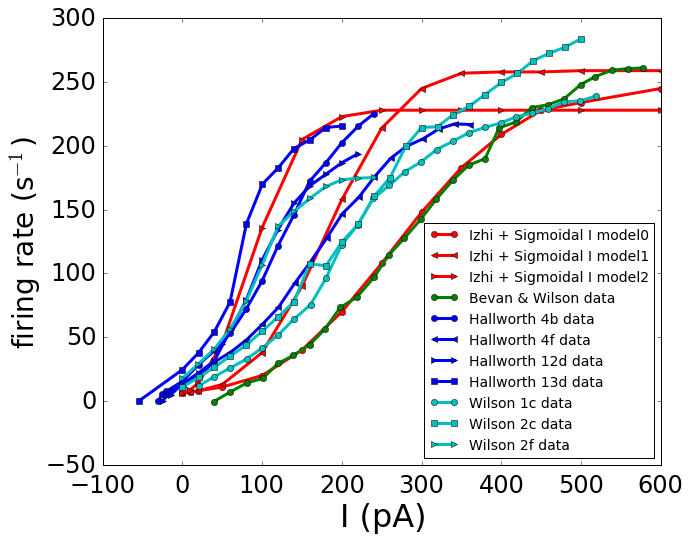

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

constIlist = [0, 10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600]

Iarr = np.asarray (constIlist)

# Plotting just the rates:
#plt.figure(figsize=(8,4))
#plt.clf;
#plt.plot (constIlist, (_Imax/(1+np.exp(-_k*(Iarr-_I0))) - _Imax/(1+np.exp(_k*_I0))), color='r',marker='o')
#plt.xlabel('I')
#plt.ylabel('Isig')
#plt.show()

# Any additional mods to _k, _Imax etc?
_k = 0.014
_I0=300
_Imax=600
rates, isiRates = abcplus_rate_sweep(constIlist)
_k = 0.023
_I0=200
_Imax=650
rates1, isiRates1 = abcplus_rate_sweep(constIlist)
_k = 0.035
_I0=100
_Imax=550
rates2, isiRates2 = abcplus_rate_sweep(constIlist)

# Plotting alongside Bevan-Wilspon data.
plt.figure(figsize=(10,8))
plt.clf;
plt.plot (constIlist, rates, color='r', marker='o', label='Izhi + Sigmoidal I model0',linewidth=3)
plt.plot (constIlist, rates1, color='r', marker='<', label='Izhi + Sigmoidal I model1',linewidth=3)
plt.plot (constIlist, rates2, color='r', marker='>', label='Izhi + Sigmoidal I model2',linewidth=3)

# Load BevanWilson data.
BW = np.loadtxt(open("./published_data/STN/Bevan_Wilson_Fig_6b.csv","rb"),delimiter=",",skiprows=1)
plt.plot (BW[:,0], BW[:,1], marker='o', color='g', label='Bevan & Wilson data',linewidth=3)

# Hallworth et al 2003
HW4b = np.loadtxt(open("./published_data/STN/Hallworth_Fig_4b_i.csv","rb"),delimiter=",",skiprows=1)
plt.plot (HW4b[:,0], HW4b[:,1], marker='o', color='b', label='Hallworth 4b data',linewidth=3)
HW4f = np.loadtxt(open("./published_data/STN/Hallworth_Fig_4f_i.csv","rb"),delimiter=",",skiprows=1)
plt.plot (HW4f[:,0], HW4f[:,1], marker='<', color='b', label='Hallworth 4f data',linewidth=3)
HW12d = np.loadtxt(open("./published_data/STN/Hallworth_Fig_12d_i.csv","rb"),delimiter=",",skiprows=1)
plt.plot (HW12d[:,0], HW12d[:,1], marker='>', color='b', label='Hallworth 12d data',linewidth=3)
HW13d = np.loadtxt(open("./published_data/STN/Hallworth_Fig_13d_i.csv","rb"),delimiter=",",skiprows=1)
plt.plot (HW13d[:,0], HW13d[:,1], marker='s', color='b', label='Hallworth 13d data',linewidth=3)

# Wilson 2004
W1c = np.loadtxt(open("./published_data/STN/Wilson_1c.csv","rb"),delimiter=",",skiprows=1)
plt.plot (W1c[:,0], W1c[:,1], marker='o', color='c', label='Wilson 1c data',linewidth=3)
W2c = np.loadtxt(open("./published_data/STN/Wilson_2c.csv","rb"),delimiter=",",skiprows=1)
plt.plot (W2c[:,0], W2c[:,1], marker='s', color='c', label='Wilson 2c data',linewidth=3)
W2f = np.loadtxt(open("./published_data/STN/Wilson_2f.csv","rb"),delimiter=",",skiprows=1)
plt.plot (W2f[:,0], W2f[:,1], marker='>', color='c', label='Wilson 2f data',linewidth=3)

plt.xlabel('I',fontsize=32)
plt.ylabel('Firing rate per second',fontsize=32)
#plt.title('STN ABCTSigI model f-I curve',fontsize=28,y=1.05)
plt.xlabel('I (pA)',fontsize=32)
plt.ylabel('firing rate (s$^{-1}$)',fontsize=28)
plt.tick_params(axis='x', labelsize=24, pad=8)
plt.tick_params(axis='y', labelsize=24, pad=8)
plt.legend(loc=4,fontsize=14)
plt.savefig('/home/seb/izhibg/GPR_Izhikevich/labbook/STN_f-I.svg')
plt.show()

#### Note on curves above 2016-05-13
On 2016-05-13 I added Hallworth 2003 and Wilson et al 2004 data to the above (blue and cyan curves) to get a feel for the variation in neurons.

It would seem to be realistic to vary _k, _I0 and _Imax as follows:

* Imax: 550 to 650
* I0: 100 to 300
* k: 0.012 to 0.035

Can I draw these from suitable normal distributions?


### 2015-12-08
The curve above from the model looks nicely matched to the data from the Bevan and Wilson paper! Now I need to find some suitable numbers for the synaptic properties of STN neurons - for the GABAergic connections from GPe and for the glutamatergic inputs from Striatum.

In "Using a hybrid neuron in physiologically inspired models of the basal ganglia" (doi:10.3389/fncom.2013.00088) there are tables of synaptic conductances. The origin is not given explicitly. However, for now, lets use (from Table 1b in that paper):

GPe->STN synaptic conductance: 0.025 with delay 2 ms.
Cortex->STN conductance: 0.2, delay 6 ms.

### Read and view model parameters from the SpineML models

Compare the sigmoidal and non-sigmoidal parameters. The only difference is the current transfer function.

In [33]:
modeldir = '/home/seb/izhibg/GPR_Izhikevich/Izhi_STNPlus';
expt = 0;
import sys
sys.path.append("../analysis")
import read_abc_model_xml as abcread
a,b,c,d,A,B,C,T,vpeak,vinit,uinit = abcread.read_abc_model_xml (modeldir,expt)
print ('Current Izhi STNPlus model parameters')
print ('---------------------------------')
print ('a={0} b={1} c={2}, d={3}'.format(a,b,c,d))
print ('A={0} B={1} C={2}'.format(A,B,C))
print ('T={0} vpeak={1}'.format(T,vpeak))
print ('\n(as read from {0})'.format(modeldir))

modeldir = '/home/seb/izhibg/GPR_Izhikevich/Izhi_STN';
a,b,c,d,A,B,C,T,vpeak,vinit,uinit = abcread.read_abc_model_xml (modeldir,expt)
print ('\nCompare with Izhi STN model parameters')
print ('--------------------------------------')
print ('a={0} b={1} c={2}, d={3}'.format(a,b,c,d))
print ('A={0} B={1} C={2}'.format(A,B,C))
print ('T={0} vpeak={1}'.format(T,vpeak))
print ('\n(as read from {0})'.format(modeldir))

Current Izhi STNPlus model parameters
---------------------------------
a=0.03 b=0.193 c=-65.0, d=0.05
A=0.032 B=4.0 C=113.147
T=0.4 vpeak=30.0

(as read from /home/seb/izhibg/GPR_Izhikevich/Izhi_STNPlus)

Compare with Izhi STN model parameters
--------------------------------------
a=0.03 b=0.193 c=-59.0, d=0.05
A=0.032 B=4.0 C=113.147
T=0.4 vpeak=30.0

(as read from /home/seb/izhibg/GPR_Izhikevich/Izhi_STN)
